In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"jahnavisaiganta","key":"bb0095bf7c8cc439c3740a8daffb59c5"}'}

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
#permission for json to act
! chmod 600  ~/.kaggle/kaggle.json

In [ ]:
#to list all datasets in kaggle
# ! kaggle datasets list

In [ ]:
! kaggle datasets download -d jangedoo/utkface-new

utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip = zipfile.ZipFile("/content/utkface-new.zip", 'r')
zip.extractall("/content")
zip.close()

In [ ]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
path = "/content/utkface_aligned_cropped/UTKFace"

In [ ]:
age=[]
gender=[]
img_path=[]
for file in os.listdir(path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

In [ ]:
len(age)

23708

In [ ]:
dataset = pd.DataFrame({'age':age,'gender':gender,'img':img_path})

In [ ]:
dataset.head()

,age,gender,img
0,24,0,24_0_0_20170117150007795.jpg.chip.jpg
1,9,0,9_0_0_20170120133313910.jpg.chip.jpg
2,8,1,8_1_0_20170109205329922.jpg.chip.jpg
3,50,1,50_1_0_20170110154254311.jpg.chip.jpg
4,26,1,26_1_0_20170109141214949.jpg.chip.jpg


In [ ]:
dataset.shape

(23708, 3)

In [ ]:
train_ds = dataset.sample(frac=1,random_state=0).iloc[:20000]
test_ds = dataset.sample(frac=1,random_state=0).iloc[20000:]

In [ ]:
train_ds.shape

(20000, 3)

In [ ]:
test_ds.shape

(3708, 3)

In [ ]:
train_gen = ImageDataGenerator(rescale=1.0/255 ,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True)
test_gen=  ImageDataGenerator(rescale=1.0/255)


In [ ]:
train_dataset_gen= train_gen.flow_from_dataframe(train_ds,
                                                 directory=path,
                                                 x_col='img',
                                                 y_col=['age','gender'],
                                                 target_size=(200,200),
                                                 class_mode='multi_output')
test_dataset_gen= test_gen.flow_from_dataframe(test_ds,
                                                 directory=path,
                                                 x_col='img',
                                                 y_col=['age','gender'],
                                                 target_size=(200,200),
                                                 class_mode='multi_output')



Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [ ]:
import tensorflow
from tensorflow import keras
# transfer learning
from keras.applications.resnet import ResNet50
from keras.layers import *
from keras.models import Model


In [ ]:
resnet = ResNet50(include_top=False,input_shape=(200,200,3))
resnet.trainable = False
output = resnet.layers[-1].output
flatten = Flatten()(output)

In [ ]:
dense_a1=Dense(512,activation='relu',kernel_initializer='he_uniform',kernel_regularizer=tensorflow.keras.regularizers.L2(0.05))(flatten)
dense_a1b= BatchNormalization()(dense_a1)
dense_a1d= Dropout(0.8)(dense_a1b)
dense_a2= Dense(512,activation='relu',kernel_initializer='he_uniform',kernel_regularizer=tensorflow.keras.regularizers.L2(0.05))(dense_a1d)
dense_a2b= BatchNormalization()(dense_a2)
dense_a2d= Dropout(0.8)(dense_a2b)


In [ ]:
dense_b1=Dense(512,activation='relu',kernel_initializer='he_uniform',kernel_regularizer=tensorflow.keras.regularizers.L2(0.05))(flatten)
dense_b1b= BatchNormalization()(dense_b1)
dense_b1d= Dropout(0.8)(dense_b1b)
dense_b2= Dense(512,activation='relu',kernel_initializer='he_uniform',kernel_regularizer=tensorflow.keras.regularizers.L2(0.05))(dense_b1d)
dense_b2b= BatchNormalization()(dense_b2)
dense_b2d= Dropout(0.8)(dense_b2b)


In [ ]:
output1 = Dense(1,activation='linear',name='age')(dense_a2d)
output2 = Dense(1,activation='sigmoid',name='gender')(dense_b2d)

In [ ]:
model = Model(inputs=resnet.input,outputs=[output1,output2])

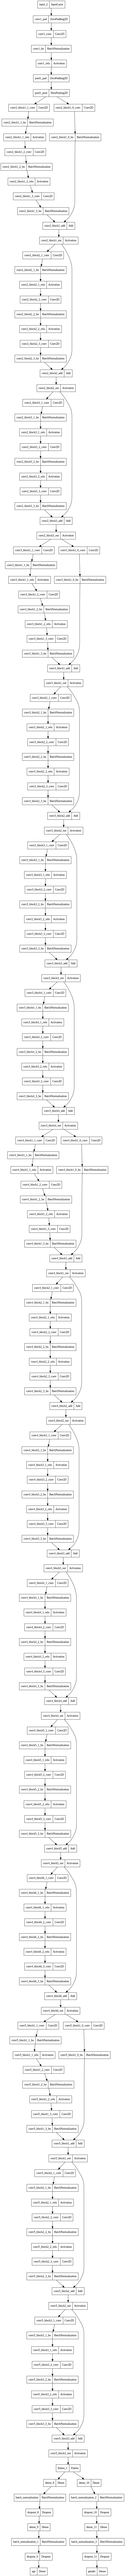

In [ ]:
from keras.utils import plot_model
plot_model(model)

In [ ]:
from keras.callbacks import EarlyStopping
callback=EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,

)

In [ ]:
model.compile(optimizer='adam', loss={'age': 'mae', 'gender': 'binary_crossentropy'}, metrics={'age': 'mae', 'gender': 'accuracy'},loss_weights={'age':1,'gender':99})

In [ ]:
model.fit(train_dataset_gen, batch_size=100, epochs=1000, validation_data=test_dataset_gen,callbacks=callback)

Epoch 1/1000
 65/625 [==>...........................] - ETA: 1:03:31 - loss: 252.3665 - age_loss: 32.7092 - gender_loss: 1.2765 - age_mae: 32.7092 - gender_accuracy: 0.5197